#1. Extrair Palavras-chave

In [ ]:
!pip install PyPDF2 nltk

In [2]:
# Instalar bibliotecas necessárias
import os
import PyPDF2
import pandas as pd
import re  # Importação da biblioteca 're' para expressões regulares

In [ ]:
# # prompt: Acessar uma pasta no google drive
# from google.colab import drive
# import os
# drive.mount('/content/drive')

# folder_path = '/content/drive/MyDrive/IC/Colab/Base Artigos FCA/'

# print("Arquivos na pasta 'artigos':", os.listdir(folder_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Arquivos na pasta 'artigos': ['Classi\ue003cação, Aprendizado de Máquina, Programação por Metas, COVID-19..pdf', 'Berth allocation · Metaheuristics · Time windows constraints · Data generator.pdf', 's41598-023-37871-x.pdf', 'Matrix Completion, proximal gradient algorithm, soft-thresholding, recommender systems.pdf', 'Transporte fretado, problema de roteamento de ve´ıculos, modelagem de fluxo em arcos..pdf', '—reliability, RCM, engineering, maintenance, MLE, maximum likelihood estimation, neural network, keras, tensorflow, LSTM, asset, management, industry.pdf', 'Local interpretability; Choquet integral; Machine learning; Shapley values.pdf', 'signal extraction, sensors design, Shapley value.pdf', 'Cutting stock problem · Multiperiod cutting stock problem · Heuristics.pdf', 'Goal programming, lot-sizing problems, cutting-stock problems, integrated problem

In [ ]:
# Clonar o repositório do GitHub
!rm -rf IC_Agrupamento
!git clone https://github.com/VitorIglesias/IC_Agrupamento.git

folder_path = '/content/IC_Agrupamento/artigos/'

print("Arquivos na pasta 'artigos':", os.listdir(folder_path))

'# Clonar o repositório do GitHub\n!rm -rf IC_Agrupamento\n!git clone https://github.com/VitorIglesias/IC_Agrupamento.git\n\nfolder_path = \'/content/IC_Agrupamento/artigos/\'\n\nprint("Arquivos na pasta \'artigos\':", os.listdir(folder_path))'

In [43]:
# Lista de variantes de "Palavras-chave" ou "Keywords"
keyword_variants = [
    "Palavras-chave", "Keywords", "palavras-chave", "palavras chave",
    "keywords", "PALAVRAS CHAVE", "Palavras Chave", "KEYWORDS", "Key words", "Key Words", "Index Terms", "Palavras-chave."
]

In [44]:
# Função para extrair texto do PDF
def extract_text_from_pdf(folder_path):
    with open(folder_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
    return text

# Função para recompor palavras divididas no final da linha (ex.: "bioen-" + "genharia" = "bioengenharia")
def fix_hyphenated_words(text):
    # Usamos uma expressão regular para encontrar palavras divididas por hifens no final da linha
    return re.sub(r'(\w+)-\n(\w+)', r'\1\2', text)

# Função para corrigir erros comuns de caracteres acentuados na extração de PDFs
def fix_common_pdf_encoding_errors(text):
    # Substituições de caracteres mal formados
    replacements = {
        "´ı": "í",    # Corrigir "í" errado
        "´a": "á",    # Corrigir "á" errado
        "´e": "é",    # Corrigir "é" errado
        "´o": "ó",    # Corrigir "ó" errado
        "´u": "ú",    # Corrigir "ú" errado
        "ﬂ": "fl",    # Corrigir "ﬂ" (ligadura para "fl")
        "ﬁ": "fi",    # Corrigir "ﬁ" (ligadura para "fi")
    }

    # 1. Substituir todos os caracteres incorretos pelos corretos
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)

    # 2. Remover apenas os espaços incorretos
    corrected_chars = '|'.join(re.escape(c) for c in replacements.values())

    # Verificar se o espaço é seguido por um caractere corrigido sem ser parte de uma palavra composta
    text = re.sub(rf'(\w)\s+({corrected_chars})', r'\1\2', text)  # Remove espaço se for entre uma palavra e caractere corrigido

    return text

# Função para substituir '\n' no meio de palavras por um espaço
def corrigir_quebra_linha_no_meio(text):
    # Substituir '\n' que aparece no meio de palavras (entre letras) por um espaço
    text = re.sub(r'\n', ' ', text)
    return text



# Função para localizar a seção de palavras-chave e extrair seu conteúdo
def extract_keywords_from_section(text):
    # Recompõe palavras que foram divididas por hífen no final de linhas
    text = fix_hyphenated_words(text)

    text = fix_common_pdf_encoding_errors(text)

    text = corrigir_quebra_linha_no_meio(text)
    # Criar o padrão da expressão regular para todas as variantes
    keyword_pattern = '|'.join([re.escape(kw) for kw in keyword_variants])

    # Procurar pela seção de palavras-chave com todas as variantes, incluindo "Index Terms"
    keyword_match = re.search(rf'({keyword_pattern})(?:—|:|.)?(.*?)(\n\n|\n\s|\.|\nIntrodução|\nAbstract|1|)', text, re.IGNORECASE | re.DOTALL)

    if keyword_match:
        # Extrair a parte que contém as palavras-chave
        keywords_text = keyword_match.group(2)

        # Separar as palavras-chave, removendo também quebras de linha
        keywords = re.split(r'[;,·]\s*|\n1', keywords_text)

        # Remover travessão (—) ou ":" que podem estar no início das palavras-chave e espaços
        keywords = [kw.strip().lstrip(':—- ').strip() for kw in keywords if kw.strip() and len(kw.strip()) > 1]


        return keywords
    else:
        return []

In [46]:
# Lista para armazenar os dados
data = []

# Percorrer todos os PDFs na pasta
for filename in os.listdir(folder_path):
    if filename.endswith(".pdf"):
        file_path = os.path.join(folder_path, filename)

        # Extrair o texto do PDF
        text = extract_text_from_pdf(file_path)

        # Extrair palavras-chave da seção "Palavras-chave" ou "Keywords"
        keywords = extract_keywords_from_section(text)

        # Adicionar os dados à lista
        data.append([filename, keywords])

df_keywords = pd.DataFrame(data, columns=['Arquivo', 'Palavras-chave'])

# Mostrar o DataFrame final
df_keywords

/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:151: PdfReadWarning:

Advanced encoding [] not implemented yet



,Arquivo,Palavras-chave
0,"Classicação, Aprendizado de Máquina, Progr...","[Classicação, Aprendizado de Máquina, Program..."
1,Berth allocation · Metaheuristics · Time windo...,"[Berth allocation, Metaheuristics, Time window..."
2,s41598-023-37871-x.pdf,[]
3,"Matrix Completion, proximal gradient algorithm...","[Matrix Completion, proximal gradient algorith..."
4,"Transporte fretado, problema de roteamento de ...","[Transporte fretado, problema de roteamento de..."
5,"—reliability, RCM, engineering, maintenance, M...","[reliability, RCM, engineering, maintenance, M..."
6,Local interpretability; Choquet integral; Mach...,"[Local interpretability, Choquet integral, Mac..."
7,"signal extraction, sensors design, Shapley val...","[signal extraction, sensors design, Shapley va..."
8,Cutting stock problem · Multiperiod cutting st...,"[Cutting stock problem, Multiperiod cutting st..."
9,"Goal programming, lot-sizing problems, cutting...","[Goal programming, lot-sizing problems, cuttin..."


In [ ]:
# Caminho para salvar o arquivo no seu computador
output_file_path = 'Dfkeywords.xlsx'

# Salvando o DataFrame como arquivo .xlsx
df_keywords.to_excel(output_file_path, index=False)

print(f"Arquivo salvo com sucesso em: {output_file_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Parte 2: Grafo


In [ ]:
!pip install python-louvain
!pip install cairocffi

In [3]:
import plotly.express as pex
import plotly.graph_objects as go
import plotly.offline as py
from igraph import Graph as IGraph
import igraph
import leidenalg as le
import community as lo
import pandas as pd
from collections import Counter

In [4]:
df_keywords = pd.read_excel('Dfkeywords (1).xlsx')
# Elimina trabalhos sem palavras-chave e prepara dados
# elimina trabalhos sem palavras-chave
ligacoes = []
todasPalavras = []
for lista in df_keywords['Palavras-chave'].values:
    lista = lista.split(' , ')
    lista.sort()
    for palavra in lista:
        todasPalavras.append(palavra.lower())
    for i in range(1,len(lista)):
         ligacoes.append([lista[0].lower(), lista[i].lower()])

qtdeRepTodasPalavras = []
MAX = 0
for palavra in todasPalavras:
    x = [palavra, todasPalavras.count(palavra)]
    if x not in qtdeRepTodasPalavras:
        qtdeRepTodasPalavras.append(x)

qtdeRepTodasPalavras = sorted(qtdeRepTodasPalavras, key=lambda tup: tup[1], reverse=True)
print("Total Top Topic: ",len(qtdeRepTodasPalavras))

grafo = []
for l in ligacoes:
    x = [l, ligacoes.count(a)]
    if x not in grafo:
        grafo.append(x)

grafo = sorted(grafo, key=lambda tup: tup[1], reverse=True)

Total Top Topic:  27


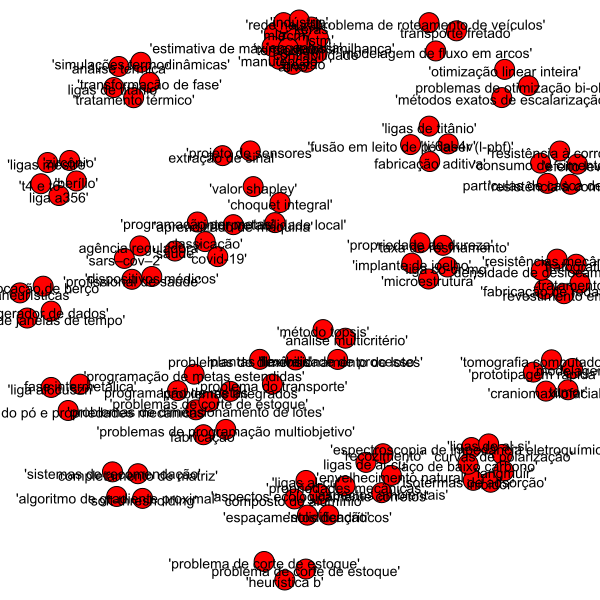

In [6]:
import pandas as pd
from collections import Counter
import igraph as ig

# Carregar o DataFrame
df_keywords = pd.read_excel('Dfkeywords (1).xlsx')
# Lista para armazenar todas as palavras e ligações
# Listas para armazenar todas as palavras e ligações
# Lista para armazenar todas as palavras e ligações
todasPalavras = []
ligacoes = []

# Processar cada linha de palavras-chave
for lista in df_keywords['Palavras-chave'].values:
    lista = [palavra.strip().lower() for palavra in lista.split(',')]
    todasPalavras.extend(lista)

    # Gerar ligações entre todas as palavras-chave na lista
    for i in range(len(lista)):
        for j in range(i + 1, len(lista)):
            if lista[i] != lista[j]:  # Garantir que não estamos ligando a palavra com ela mesma
                ligacoes.append((lista[i], lista[j]))

# Usar Counter para contar ocorrências de palavras e ligações
contagem_palavras = Counter(todasPalavras)
contagem_ligacoes = Counter(ligacoes)

# Criar o grafo com igraph
g = ig.Graph.TupleList(ligacoes, directed=False, edge_attrs=['weight'])
g.es['weight'] = [contagem_ligacoes[edge.tuple] for edge in g.es]

# Layout do grafo
layout = g.layout('fr')  # Fruchterman-Reingold algorithm to place nodes

# Visualização do grafo
ig.plot(g, layout=layout, vertex_label=g.vs['name'], edge_width=[2 * w for w in g.es['weight']])


#2. Grafos, Louvain e Leiden

In [8]:
import pandas as pd
from collections import Counter

# Carregar o DataFrame
df = pd.read_excel('Dfkeywords (1).xlsx')  # Assegure-se de usar o caminho correto

# Inicialização de listas para armazenar todas as palavras e ligações
ligacoes = []
todasPalavras = []

# Processar cada linha da coluna 'Palavras-chave'
for lista in df['Palavras-chave'].values:
    if pd.isna(lista):
        continue  # Ignora linhas com valores nulos diretamente
    
    lista = lista.split(',')
    lista = [palavra.strip().lower() for palavra in lista if palavra.strip() != '']  # Limpeza e normalização
    todasPalavras.extend(lista)
    
    # Criar ligações entre a primeira palavra e as demais palavras da lista
    primeira_palavra = lista[0] if lista else None
    if primeira_palavra:
        for palavra in lista[1:]:  # Começa do segundo elemento
            ligacoes.append((primeira_palavra, palavra))

# Contagem de ocorrências usando Counter para eficiência
contagem_palavras = Counter(todasPalavras)
contagem_ligacoes = Counter(ligacoes)

# Ordenar palavras e ligações por frequência
sorted_palavras = sorted(contagem_palavras.items(), key=lambda item: item[1], reverse=True)
sorted_ligacoes = sorted(contagem_ligacoes.items(), key=lambda item: item[1], reverse=True)

# Imprimir resultados
print("Total de Tópicos Principais: ", len(contagem_palavras))
print("Ligações mais comuns: ", sorted_ligacoes[:10])


Total de Tópicos Principais:  114
Ligações mais comuns:  [(("classicação'", "'aprendizado de máquina'"), 1), (("classicação'", "'programação por metas'"), 1), (("classicação'", "'covid-19'"), 1), (("classicação'", "'saúde'"), 1), (("alocação de berço'", "'metaheurísticas'"), 1), (("alocação de berço'", "'restrições de janelas de tempo'"), 1), (("alocação de berço'", "'gerador de dados'"), 1), (("completamento de matriz'", "'algoritmo de gradiente proximal'"), 1), (("completamento de matriz'", "'soft-thresholding'"), 1), (("completamento de matriz'", "'sistemas de recomendação'"), 1)]


Comunidades Louvain: Clustering with 114 elements and 20 clusters
[ 0] 'aprendizado de máquina', 'saúde', 'valor shapley', classicação',
     'programação por metas', 'covid-19', interpretabilidade local', 'choquet
     integral', extração de sinal', 'projeto de sensores', agência
     reguladora', 'dispositivos médicos', 'sars–cov–2', 'profissional de
     saúde'
[ 1] 'problemas integrados', 'problemas de dimensionamento de lotes',
     'problemas de corte de estoque', problemas de dimensionamento de lotes',
     programação de metas', 'programação de metas estendidas', fabricação',
     'problemas de programação multiobjetivo', 'problema do transporte',
     'plantas flexíveis', 'flexibilidade de processo', 'análise
     multicritério', 'método topsis'
[ 2] confiabilidade', 'rcm', 'engenharia', 'manutenção', 'mle', 'estimativa de
     máxima verossimilhança', 'rede neural', 'keras', 'tensorflow', 'lstm',
     'ativo', 'gestão ', 'indústria'
[ 3] 'propriedades mecânicas', ligas de al-

C:\Users\vitor\AppData\Local\Temp\ipykernel_16776\983254039.py:2: DeprecationWarning:

This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.



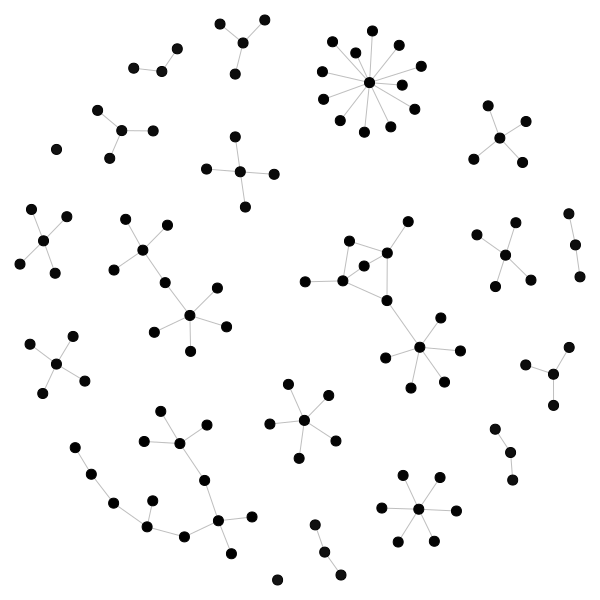

In [9]:
import igraph as ig
import louvain as lo
import leidenalg as le

# Suponha que sorted_palavras e sorted_ligacoes já foram definidos
vertices = [{'name': elem[0], 'weight': elem[1]} for elem in sorted_palavras]
arestas = [{'source': elem[0][0], 'target': elem[0][1], 'weight': elem[1]} for elem in sorted_ligacoes]

# Criando o grafo com igraph
g = ig.Graph.DictList(vertices=vertices, edges=arestas, directed=False, vertex_name_attr='name')

# Detecção de comunidades com o método Louvain
partition_lo = lo.find_partition(g, lo.ModularityVertexPartition, weights='weight')
num_communities_lo = len(partition_lo)
print("Comunidades Louvain:", partition_lo)
print("Número de comunidades Louvain:", num_communities_lo)

# Plotar o grafo Louvain
color_dict = {i: partition_lo.membership[i] for i in range(len(partition_lo.membership))}
g.vs['color'] = [color_dict[x] for x in range(len(g.vs))]
layout = g.layout('fr')  # Layout Fruchterman-Reingold
ig.plot(g, layout=layout, vertex_color=g.vs['color'], vertex_size=10, edge_width=1, edge_color='gray', target='louvain.png')

# Detecção de comunidades com o método Leiden
partition_le = le.find_partition(g, le.ModularityVertexPartition, weights='weight')
num_communities_le = len(partition_le)
print("Comunidades Leiden:", partition_le)
print("Número de comunidades Leiden:", num_communities_le)

# Plotar o grafo Leiden
color_dict = {i: partition_le.membership[i] for i in range(len(partition_le.membership))}
g.vs['color'] = [color_dict[x] for x in range(len(g.vs))]
layout = g.layout('fr')  # Layout Fruchterman-Reingold
ig.plot(g, layout=layout, vertex_color=g.vs['color'], vertex_size=10, edge_width=1, edge_color='gray', target='leiden.png')
